# Project: Airport Taxi Rides (Time Series)

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# statsmodel
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [34]:
# Adjust display settings
%matplotlib inline
plt.rc('figure', figsize=(18,6))

## Preparation

In [35]:
try:
    df = pd.read_csv(
        'datasets/taxi.csv',
        index_col='datetime',
        parse_dates=['datetime']
    )
except:
    df = pd.read_csv(
        '/datasets/taxi.csv',
        index_col='datetime',
        parse_dates=['datetime']
    )

## Analysis

### Explore the data

In [36]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [38]:
df.sort_index(inplace=True)
print(df.index.is_monotonic_increasing)

True


Dates and times are checked for chronological order.

In [39]:
print(f"Start datetime: {df.index.min()}")

Start datetime: 2018-03-01 00:00:00


In [40]:
print(f"End datetime: {df.index.max()}")

End datetime: 2018-08-31 23:50:00


The start and end datetimes in the time series are verified.

In [41]:
df.isnull().sum()

num_orders    0
dtype: int64

No duplicated rows exist for num_orders.

In [42]:
df.shape

(26496, 1)

In [43]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


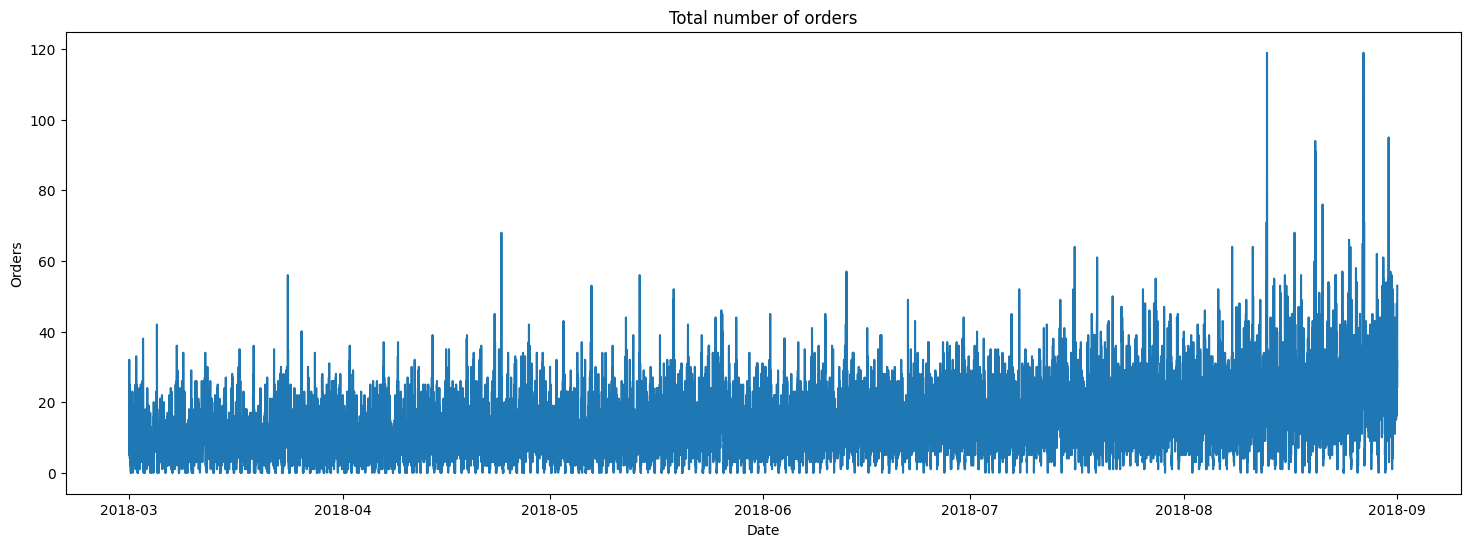

In [44]:
plt.title('Total number of orders')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.plot(df)

The time series is plotted, and the number of taxi orders show a positive trend over time across the spring and summer months.

### Resample the data

In [45]:
df = df.resample('1H').sum()

The interval of the time series' values is changed by one hour.

### Plot decomposed tables

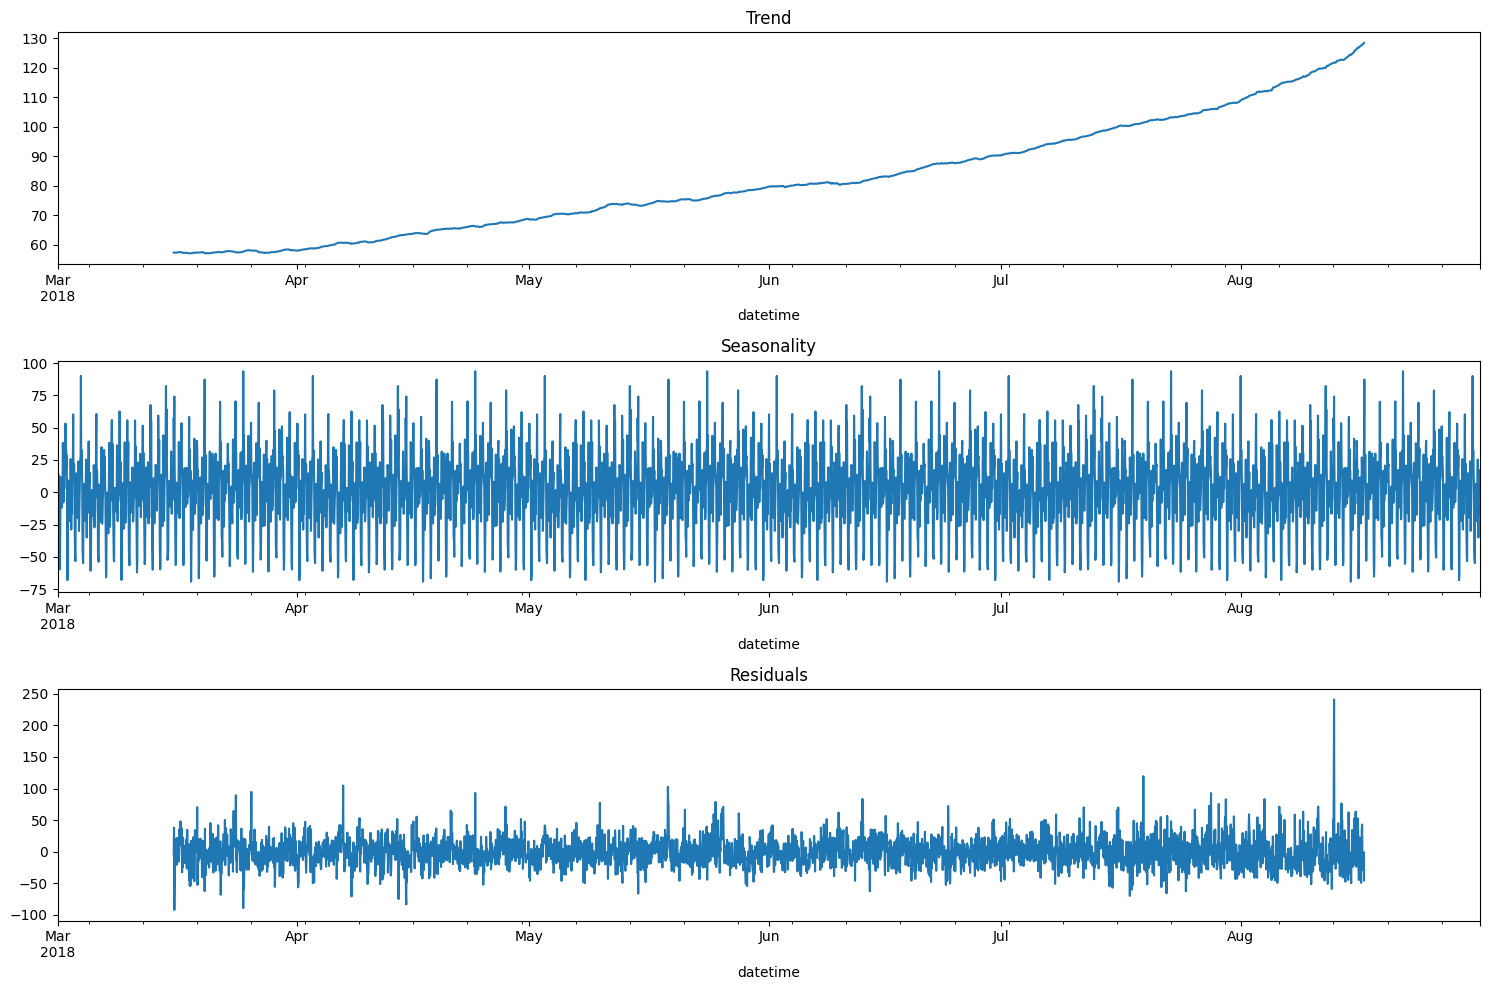

In [46]:
decomposed = seasonal_decompose(df, 'additive', period=720)

# Trend
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), figsize=(15, 10))
plt.title('Trend')

# Seasonality
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), figsize=(15, 10))
plt.title('Seasonality')

# Residuals
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), figsize=(15, 10))
plt.title('Residuals')

plt.tight_layout()

Decomposed tables are plotted. Trend represents smooth changes of the mean values of the time series without repeating patterns. Seasonality represents cyclically repeating patterns in the time series. Residuals represent noise in the data so it can generally be ignored, but is still plotted nevertheless.

### Autoregression

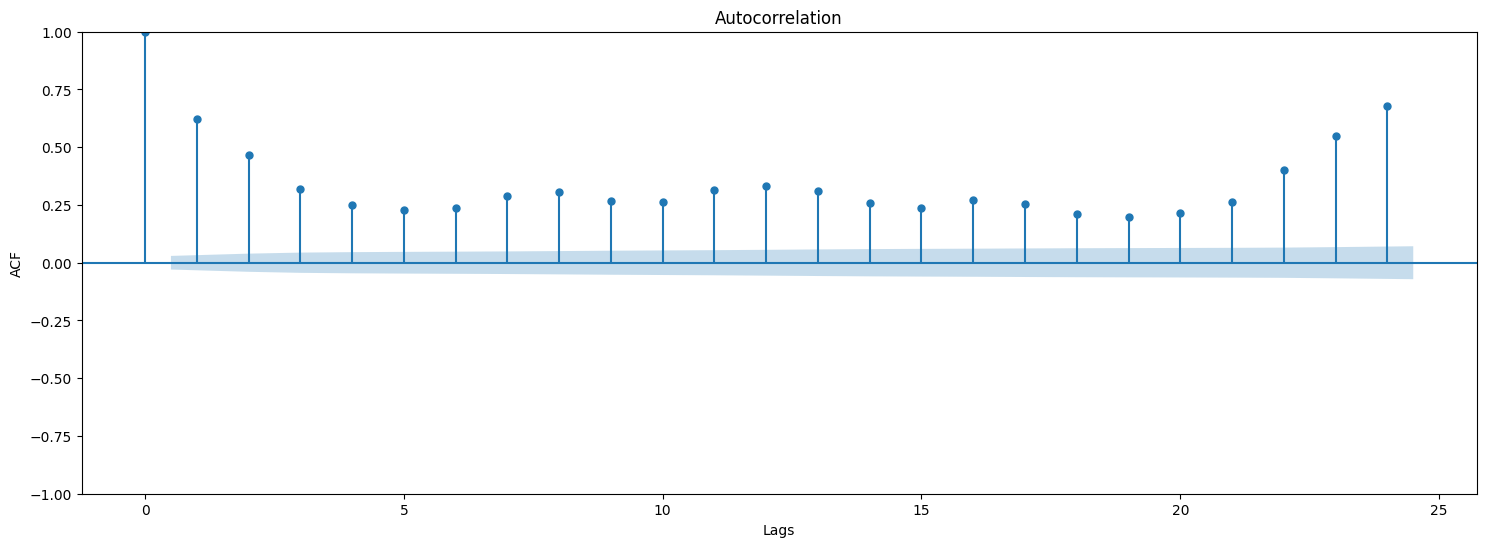

In [47]:
plot_acf(df.values, lags=24)
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

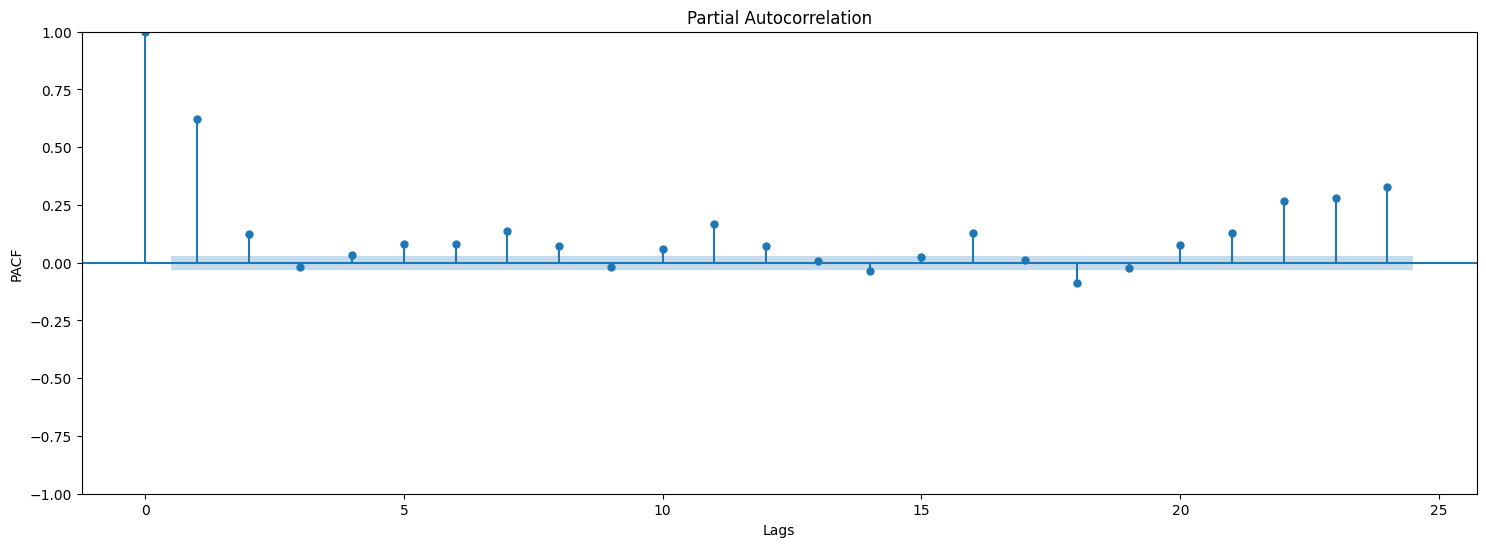

In [48]:
plot_pacf(df.values, lags=24)
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

For forecasting, autoregression is plotted using past values to predict future values. Both plots use a lag value to check/include of 24 (representing one day), while the blue represents the 95% confidence interval. The spikes that fall outside the blue area represent lags with statistically significant correlation.

The first plot uses the autocorrelation function to show the direct and indirect correlation between lagged values in our time series, whereas the second plot uses the partial autocorrelation function (also using 24 lags to check) and only shows direct correlation between lagged values.

## Training

### Feature engineering

In [49]:
def make_features(data, max_lag, rolling_mean_size):
    # Extract parts of datetime
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    # Create new feature for each lag value
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # Rolling window
    # Smooth the data in the time series
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['rolling_std'] = data['num_orders'].shift().rolling(rolling_mean_size).std()

    return data

In [50]:
make_features(df, 24, 24)

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,rolling_std
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,19,207.0,217.0,197.0,116.0,...,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,164.875000,65.948143
2018-08-31 20:00:00,154,2018,8,31,4,20,136.0,207.0,217.0,197.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.541667,63.268908
2018-08-31 21:00:00,159,2018,8,31,4,21,154.0,136.0,207.0,217.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.041667,63.105487


Features are created out of the datetime values and lags. For max lag and rolling mean size, 24 is used to capture daily seasonality for the former and a one-day window size for short-term trends for the latter. For rolling window statistics, we include rolling mean and rolling standard deviation features.

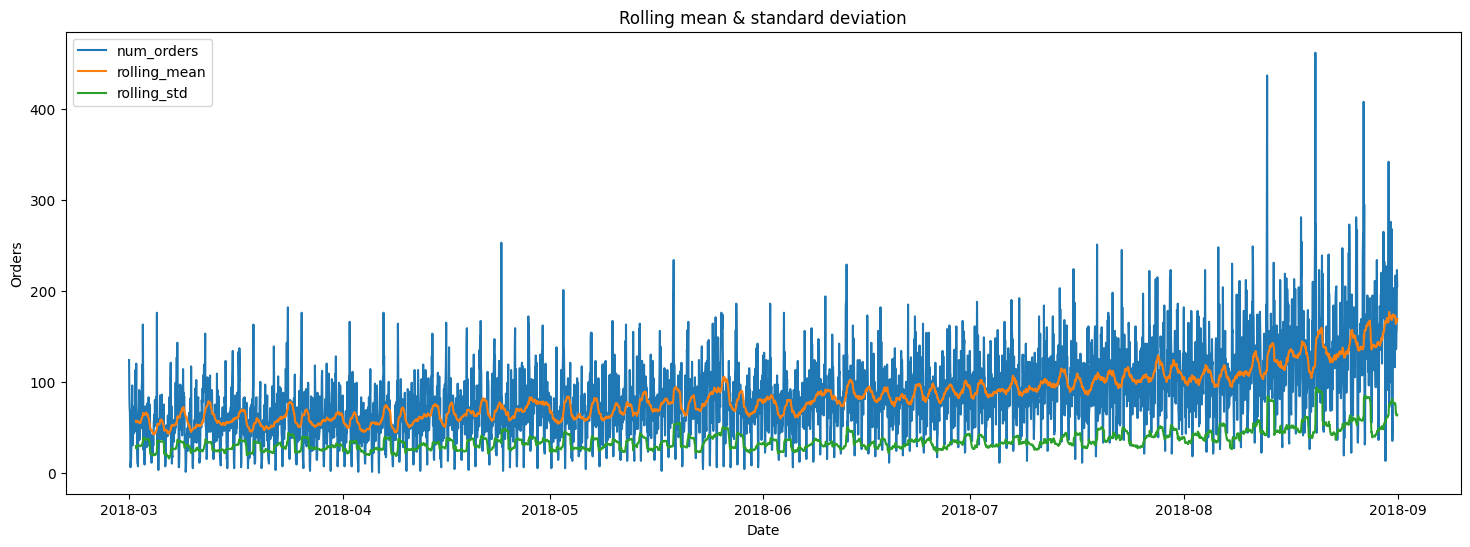

In [51]:
df_rolling_window = df[['num_orders', 'rolling_mean', 'rolling_std']]

for col in df_rolling_window.columns:
    plt.plot(df.index, df_rolling_window[col], label=col)

plt.xlabel('Date')
plt.ylabel('Orders')
plt.title('Rolling mean & standard deviation')
plt.legend(loc='best')
plt.show()

After creating new features, the time series is plotted again to visualize taxi order trends against the rolling window statistics that are now available.

In [52]:
df = df.dropna()

### Split the data

In [53]:
train_valid, test = train_test_split(df, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

In [54]:
print(train.index.min(), train.index.max())
print(valid.index.min(), valid.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-07-28 03:00:00
2018-07-28 04:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


In [55]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [56]:
# Time series cross-validation
tscv = TimeSeriesSplit()

In [57]:
def rmse(true, pred):
    return mean_squared_error(true, pred) ** 0.5

### Linear Regression

In [26]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

pred_train = model_lr.predict(features_train)
pred_valid = model_lr.predict(features_valid) # or test?

print(f'RMSE for linear regression model on the training set: {rmse(target_train, pred_train):.2f}')
print(f'RMSE for linear regression model on the validation set: {rmse(target_valid, pred_valid):.2f}')

RMSE for linear regression model on the training set: 24.60
RMSE for linear regression model on the validation set: 34.21


### Decision Tree

In [27]:
param_grid_dt = {
    'max_depth': range(1, 11)
}

model_dt = DecisionTreeRegressor(random_state=12345)
gs_dt = GridSearchCV(
    model_dt,
    param_grid=param_grid_dt,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=2
)
gs_dt.fit(features_train, target_train)

print(f'Best score for decision tree model on the training set: {gs_dt.best_score_}')
print(f'Best params for decision tree model on the training set: {gs_dt.best_params_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END .......................................

In [58]:
model_dt = DecisionTreeRegressor(max_depth=4, random_state=12345)
model_dt.fit(features_train, target_train)

pred_train_dt = model_dt.predict(features_train)
pred_valid_dt = model_dt.predict(features_valid)

print(f'RMSE for decision tree model on the training set: {rmse(target_train, pred_train_dt):.2f}')
print(f'RMSE for decision tree model on the validation set: {rmse(target_valid, pred_valid_dt):.2f}')

RMSE for decision tree model on the training set: 24.71
RMSE for decision tree model on the validation set: 41.04


### Random Forest

In [29]:
param_grid_rf = {
    'n_estimators': [10, 25, 50],
    'max_depth': [1, 5, 10]
}

model_rf = RandomForestRegressor(random_state=12345)
gs_rf = GridSearchCV(
    model_rf,
    param_grid=param_grid_rf,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=2
)
gs_rf.fit(features_train, target_train)

print(f'Best score for random forest model on the training set: {gs_rf.best_score_}')
print(f'Best params for random forest model on the training set: {gs_rf.best_params_}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .......................max_depth=1, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=25; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=25; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=25; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=25; total time=   0.1s
[CV] END .......................max_depth=1, n_estimators=25; total time=   0.1s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=1, n_es

In [59]:
model_rf = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=12345)
model_rf.fit(features_train, target_train)

pred_train_rf = model_rf.predict(features_train)
pred_valid_rf = model_rf.predict(features_valid)

print(f'RMSE for random forest model on the training set: {rmse(target_train, pred_train_rf):.2f}')
print(f'RMSE for random forest model on the validation set: {rmse(target_valid, pred_valid_rf):.2f}')

RMSE for random forest model on the training set: 13.68
RMSE for random forest model on the validation set: 33.27


For training and evaluating the different models, hyperparameters are tuned for decision tree and random forest, respectively, before comparing RMSE scores. The best RMSE scores based on the validation set are as follows: random forest (approx. 33.27), linear regression (approx. 34.21), decision tree (approx. 41.04). The best model, random forest, is used next for training against the test set.

## Testing

In [60]:
features_train_valid = train_valid.drop(['num_orders'], axis=1)
target_train_valid = train_valid['num_orders']

In [61]:
model_rf = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=12345)
model_rf.fit(features_train_valid, target_train_valid)

pred_test_rf = model_rf.predict(features_test)

print(f'RMSE for random forest model on the test set: {rmse(target_test, pred_test_rf):.2f}')

RMSE for random forest model on the test set: 44.68


Trained and evaluated against the test set, the best model (random forest) scores a little worse for RMSE (approx. 44.68, vs. 33.27 on the validation set), but is below the threshold of 48.

## Conclusion

A time series was prepared on behalf of Sweet Lift Taxi using historical data on taxi orders, with the task of predicting the amount of orders for the next hour.

After resampling the time series by one hour, new features were created for date and time, lags, and rolling window statistics. Three models were trained and evaluated on split data, with an outcome for the best model being random forest. Hyperparameter tuning for this model was kept low as to keep training time low. The RMSE score on the validation set was approximately 33.27, whereas the same metric scored 44.68 on the test set. Both scores meet the requirement of being no higher than the threshold of 48.

In summary, random forest is the recommended model to use for making predictions about taxi orders. This will provide Sweet Lift Taxi with an advantage in attracting more drivers during peak hours for airport rides.